In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
%matplotlib inline
from nilearn import plotting
from nilearn import image as nli
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn.input_data import NiftiMapsMasker
import re

/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Understanding our data
### fMRI imaging subject phenotypic information

In [2]:
# p = r"/media/nap-smasher/My Passport/malis-autism-project/brain_img/"
# with_fmri = []
# for subj in sub_list:
#     if os.path.exists(p+subj+"/session_1/rest_1/rest.nii.gz") or os.path.exists(p+subj+"/session_1/func/rest.nii.gz"):
#         with_fmri.append(subj)
# with open("preprocessing/with_func.txt", "w") as f:
#     f.writelines("\n".join(with_fmri))

In [3]:
with open("preprocessing/subj_list.txt", "r") as f:
    sub_list = f.read().splitlines()

has_fmri_path = "preprocessing/with_func.txt"
with open(has_fmri_path) as f:
    has_fmri = f.read().splitlines()

csv_path = "ABIDEII/ABIDEII_Composite_Phenotypic.csv"
df_pheno = pd.read_csv(csv_path, encoding="unicode_escape")

info_processed_subjs = df_pheno[df_pheno['SUB_ID'].isin(list(map(int,sub_list)))][['SUB_ID','SEX','DX_GROUP','AGE_AT_SCAN ','FIQ']]

# check requirements
subjs_selection = info_processed_subjs[(info_processed_subjs['AGE_AT_SCAN '] <= 40) & (info_processed_subjs['FIQ'] >= 80) & (info_processed_subjs['SUB_ID'].isin(list(map(int,has_fmri))))][['SUB_ID','SEX','DX_GROUP']]

# mark for exclusion from the dataset for ML the subjects that don't satisfy the requirements
exclusion_list = list(set(sub_list) - set(map(str,subjs_selection['SUB_ID'])))
# with open("preprocessing/exclusion_list.txt", "x") as f:
#     f.writelines("\n".join(exclusion_list))

In [4]:
exclusion_list

['28713', '29622', '28711', '28712']

In [5]:
print(f'Number of subjects processed: {len(sub_list)}')
print(f'Number of subjects satisfying the requirements: {len(subjs_selection)}')
print(f'Total autistic: {len(subjs_selection[subjs_selection["DX_GROUP"] == 1])}')
print(f'Total controls: {len(subjs_selection[subjs_selection["DX_GROUP"] == 2])}')
print(f'Females autistic: {len(subjs_selection[(subjs_selection["SEX"] == 2) & subjs_selection["DX_GROUP"] == 1])}')
print(f'Males autistic: {len(subjs_selection[(subjs_selection["SEX"] == 1) & (subjs_selection["DX_GROUP"] == 1)])}')
print(f'Females control: {len(subjs_selection[(subjs_selection["SEX"] == 2) & (subjs_selection["DX_GROUP"] == 2)])}')
print(f'Males control: {len(subjs_selection[(subjs_selection["SEX"] == 1) & (subjs_selection["DX_GROUP"] == 2)])}')
print(f'Total females: {len(subjs_selection[subjs_selection["SEX"] == 2])}')
print(f'Total males: {len(subjs_selection[subjs_selection["SEX"] == 1])}')

Number of subjects processed: 420
Number of subjects satisfying the requirements: 416
Total autistic: 200
Total controls: 216
Females autistic: 61
Males autistic: 139
Females control: 156
Males control: 60
Total females: 217
Total males: 199


### Find subjects with complete C-PAC output

## Computing correlation matrices from our processed fMRIs applying a Craddock Atlas

In [6]:
# data_path = r"/home/nap-smasher/Downloads/brain_data_processed/output/cpac_singul_pipeline/"
data_path = r"/media/nap-smasher/My Passport/preproc_bolds/"
subj_data_paths = os.listdir(data_path)
subj_ids_processed = [re.search(r"[0-9]{5}",p).group() for p in subj_data_paths]

labeled_subjs = {}
for p in subj_data_paths:
    sub_id = int(re.search(r"[0-9]{5}",p).group())
    # keep only those in subjs_selection
    if sub_id in list(subjs_selection['SUB_ID']):
        labeled_subjs[p] = int(df_pheno[df_pheno['SUB_ID']==sub_id]['DX_GROUP'])

preproc_bolds = [nib.load(data_path+subj) for subj in labeled_subjs.keys()]

In [7]:
len(preproc_bolds)

403

### Atlas downloaded from nilearn: fewer ROIs

In [8]:
dataset = datasets.fetch_atlas_craddock_2012(data_dir="/home/nap-smasher/Documents/malis-project-autism/preprocessing", url=None, resume=True)
dataset.keys()

dict_keys(['description', 'scorr_mean', 'tcorr_mean', 'scorr_2level', 'tcorr_2level', 'random'])

In [9]:
scorr_mean_atlas = nib.load(dataset['scorr_mean'])
print(scorr_mean_atlas.shape)
# plot = plotting.plot_prob_atlas(scorr_mean_atlas)
# plot.savefig("final_report/img/atlas.png")

(47, 56, 46, 43)


In [10]:
# tcorr_mean_atlas = nib.load(dataset['tcorr_mean'])
# print(tcorr_mean_atlas.shape)
# plotting.plot_prob_atlas(tcorr_mean_atlas)

In [11]:
# scorr_2level_atlas = nib.load(dataset['scorr_2level'])
# print(scorr_2level_atlas.shape)
# plotting.plot_prob_atlas(scorr_2level_atlas)

In [12]:
# tcorr_2level_atlas = nib.load(dataset['tcorr_2level'])
# print(tcorr_2level_atlas.shape)
# plotting.plot_prob_atlas(tcorr_2level_atlas)

In [13]:
# random_atlas = nib.load(dataset['random'])
# print(random_atlas.shape)
# plotting.plot_prob_atlas(random_atlas)

How do we choose?

**Applying scorr_mean_atlas**

From here, following <a href="https://brainhack101.github.io/introML-book/01/MAIN_tutorial_machine_learning_with_nilearn.html">other tutorial</a>

In [14]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    scorr_mean_atlas, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


## Apply atlas to fMRIs

In [ ]:
all_features = []
for i,sub in enumerate(preproc_bolds):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.transform(sub)
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(preproc_bolds)))


finished 1 of 403
finished 2 of 403
finished 3 of 403
finished 4 of 403
finished 5 of 403
finished 6 of 403
finished 7 of 403
finished 8 of 403
finished 9 of 403
finished 10 of 403
finished 11 of 403
finished 12 of 403
finished 13 of 403
finished 14 of 403
finished 15 of 403
finished 16 of 403
finished 17 of 403
finished 18 of 403
finished 19 of 403
finished 20 of 403
finished 21 of 403
finished 22 of 403
finished 23 of 403
finished 24 of 403
finished 25 of 403
finished 26 of 403
finished 27 of 403
finished 28 of 403
finished 29 of 403
finished 30 of 403
finished 31 of 403
finished 32 of 403
finished 33 of 403
finished 34 of 403
finished 35 of 403
finished 36 of 403
finished 37 of 403
finished 38 of 403
finished 39 of 403
finished 40 of 403
finished 41 of 403
finished 42 of 403
finished 43 of 403
finished 44 of 403
finished 45 of 403
finished 46 of 403
finished 47 of 403
finished 48 of 403
finished 49 of 403
finished 50 of 403
finished 51 of 403
finished 52 of 403
finished 53 of 403
fi

In [ ]:
np.save('ABIDEII/data/labels', list(labeled_subjs.values()))
np.savez_compressed('ABIDEII/data/features',x=all_features)

Text(0, 0.5, 'subjects')

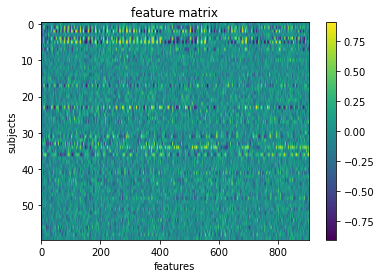

In [26]:
import matplotlib.pyplot as plt

plt.imshow(all_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')


# TODO: same with CC200 atlas -> 200 ROIs NOT WORKING!

In [28]:
CC200_atlas = nib.load("preprocessing/cc200_roi_atlas.nii.gz")
labels_path = "preprocessing/CC200_ROI_labels.csv"
CC200_atlas.shape

(63, 75, 61)

**So this atlas is 3D instead of 4D!**

In [29]:
masker_CC200 = input_data.NiftiMapsMasker(
    CC200_atlas, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()
correlation_measure_CC200 = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


In [30]:
features_CC200 = []

for i,sub in enumerate(preproc_bolds):
    # extract the timeseries from the ROIs in the atlas
    time_series_CC200 = masker_CC200.fit_transform(sub)
    print("ts shape: ",time_series_CC200.shape)
    # create a region x region correlation matrix
    correlation_matrix_CC200 = correlation_measure_CC200.fit_transform([time_series_CC200])[0]
    print("cm shape: ",correlation_matrix_CC200)
    # add to our container
    features_CC200.append(correlation_matrix_CC200)
    # keep track of status
    print('finished %s of %s'%(i+1,len(preproc_bolds)))


ts shape:  (947, 1)
cm shape:  []
finished 1 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (172, 1)
cm shape:  []
finished 2 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 3 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 4 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 5 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 6 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 7 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 8 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 9 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 10 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 11 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 12 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 13 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (128, 1)
cm shape:  []
finished 14 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (128, 1)
cm shape:  []
finished 15 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 16 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 17 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 18 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (210, 1)
cm shape:  []
finished 19 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 20 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (156, 1)
cm shape:  []
finished 21 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 22 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 23 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 24 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 25 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 26 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 27 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 28 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 29 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 30 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 31 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (210, 1)
cm shape:  []
finished 32 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 33 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 34 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 35 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 36 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 37 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 38 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 39 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 40 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 41 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 42 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (156, 1)
cm shape:  []
finished 43 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 44 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 45 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 46 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 47 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 48 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 49 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 50 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 51 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 52 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 53 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 54 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (156, 1)
cm shape:  []
finished 55 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 56 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 57 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 58 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 59 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (210, 1)
cm shape:  []
finished 60 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (128, 1)
cm shape:  []
finished 61 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (156, 1)
cm shape:  []
finished 62 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 63 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 64 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (156, 1)
cm shape:  []
finished 65 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (152, 1)
cm shape:  []
finished 66 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 67 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 68 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 69 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 70 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (947, 1)
cm shape:  []
finished 71 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 72 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (180, 1)
cm shape:  []
finished 73 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


ts shape:  (120, 1)
cm shape:  []
finished 74 of 272


/home/nap-smasher/Software/anaconda3/envs/lab0/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


KeyboardInterrupt: 

In [ ]:
plt.imshow(features_CC200, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')


In [ ]:
features_CC200[3].shape

In [ ]:
all_features

In [ ]:
labels = pd.read_csv(labels_path,delimiter="|")
labels_ROInumber = list(labels['ROI number'])
# labels_HarvardOxford = labels['Harvard-Oxford']

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
# using only 1 of the timeseries because it's a heavy operation
correlation_matrix_from_file = correlation_measure.fit_transform([timeseries[0]])[0]
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix_from_file, 0)
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix_from_file, figure=(15, 12), labels=labels_ROInumber,
                     vmax=0.8, vmin=-0.8, reorder=True, colorbar=True)

In [ ]:
np.arctanh(correlation_matrix_from_file)

In [ ]:
from nilearn import plotting
coord_list = list(labels[" center of mass"])
coords = []
for l in coord_list:
    splits = [x.replace("(","").replace(")","") for x in str(l).split(";")]
    coords.append(np.array(splits))
# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()


In [ ]:
from nilearn.input_data import NiftiMapsMasker
dataset = datasets.fetch_atlas_craddock_2012()

masker = NiftiMapsMasker(maps_img="/home/nap-smasher/nilearn_data/craddock_2012/scorr05_mean_all.nii.gz", standardize=True,
                         memory='nilearn_cache')

time_series = masker.fit_transform(preproc_bolds[0],
                                   confounds=None)

In [ ]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# matrices are ordered for block-like representation
labels_roi = np.arange(0,43)
plotting.plot_matrix(correlation_matrix, figure=(15, 12), labels=labels_roi,
                     vmax=0.8, vmin=-0.8, reorder=True, colorbar=True)

In [ ]:
correlation_matrix

In [ ]:
coord_list = list(labels[" center of mass"])
coords = []
for l in coord_list:
    splits = [x.replace("(","").replace(")","") for x in str(l).split(";")]
    coords.append(np.array(splits))
# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

In [ ]:
timeseries

In [ ]:
# import json
# with open("/home/nap-smasher/Downloads/brain_data_processed/output/cpac_singul_pipeline/28778_session_1/func/sub-28778_session_1_task-func-1_atlas-CC200_desc-Mean-1_timeseries.json") as f:
#     ts_dict = json.load(f)

In [ ]:
# ts_dict.keys()

In [ ]:
# len(ts_dict['CpacProvenance'])

In [ ]:
atlas_ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename_ho = dataset_ho.maps
labels_ho = dataset_ho.labels

In [ ]:
# labels_ho